# 20220327-zoo-phases
- Phase behavior (per-trace, across simpoints)
    - IPC
    - MPKI
    
- Collecting statistics (from `Pythia` directory):
    - Create Zoo sweep by running `./experiments/prefetcher_zoo.py condor_setup`
    - Evaluate Zoo sweep by running `./experiments/prefetcher_zoo.py eval`
    - If tuning prefetchers by degree:
        1. Create degree tuning sweep by running `./experiments/prefetcher_degree_sweep.py condor_setup`
        2. Evaluate degree tuning sweep by running `./experiments/prefetcher_degree_sweep.py eval`
        3. Copy degree tuning ChampSim result files to the Zoo sweep ChampSim results directory
        4. Evaluate combined sweep by running `./experiments/prefetcher_zoo.py eval --best-degree-csv <output of (2)>`

In [1]:
from collections import defaultdict
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display

from utils import utils, stats

In [2]:
data_path = '/u/cmolder/GitHub/Pythia/out/prefetcher_zoo.csv'
data_path_cs = '/u/cmolder/GitHub/Pythia/out/prefetcher_zoo_cloudsuite.csv'
weight_path = '/scratch/cluster/cmolder/traces/prefetcher_zoo/champsim/weights.txt'

df = utils.read_data_file(data_path)
df_cs = utils.read_data_file(data_path_cs)
df = df.append(df_cs)
weights = utils.read_weights_file(weight_path)

In [3]:
pd.set_option('display.max_rows', 100)
df[(df.trace == 'lbm')]

full_trace trace simpoint    prefetcher  degree    accuracy   coverage  \
924  lbm_1004B   lbm    1004B         bingo    (1,)   99.999755  22.063326   
925  lbm_1004B   lbm    1004B            bo    (4,)   99.924389  14.181567   
926  lbm_1004B   lbm    1004B        pythia    (1,)   99.989748  19.355351   
927  lbm_1004B   lbm    1004B          sisb    (1,)  100.000000   0.761132   
928  lbm_1004B   lbm    1004B           sms    (8,)  100.000000  23.025351   
929  lbm_1004B   lbm    1004B      bingo_bo  (1, 1)   99.995245  22.705018   
930  lbm_1004B   lbm    1004B           spp    (1,)   99.937368   7.292429   
931  lbm_1004B   lbm    1004B    bingo_sisb  (1, 6)   99.997790  22.028555   
932  lbm_1004B   lbm    1004B  bingo_pythia  (1, 1)   99.990296  22.709467   
933  lbm_1004B   lbm    1004B     bingo_sms  (1, 4)   99.999059  23.010498   
934  lbm_1004B   lbm    1004B     bo_pythia  (2, 1)   99.984642  20.273570   
935  lbm_1004B   lbm    1004B     bingo_spp  (1, 1)   99.999269  21.950183   
936  lbm_1004B   lbm    1004B       bo_sisb  (1, 8)   99.796918  13.992037   
937  lbm_1004B   lbm    1004B        bo_sms  (2, 5)   99.995292  22.908922   
938  lbm_1004B   lbm    1004B        bo_spp  (8, 1)   99.989911  16.792347   
939  lbm_1004B   lbm    1004B   pythia_sisb  (1, 7)   99.988936  19.348027   
940  lbm_1004B   lbm    1004B    pythia_sms  (1, 7)   99.990862  22.998588   
941  lbm_1004B   lbm    1004B    pythia_spp  (1, 1)   99.989284  19.382456   
942  lbm_1004B   lbm    1004B      sisb_sms  (8, 8)   99.999765  23.027199   
943  lbm_1004B   lbm    1004B      sisb_spp  (1, 1)   99.999450   7.304270   
944  lbm_1004B   lbm    1004B       sms_spp  (6, 1)   99.999295  22.952249   
945    lbm_94B   lbm      94B         bingo    (1,)   99.997947  22.043680   
946    lbm_94B   lbm      94B            bo    (3,)   99.879948  13.435628   
947    lbm_94B   lbm      94B          sisb    (7,)  100.000000   1.009463   
948    lbm_94B   lbm      94B        pythia    (1,)   99.989227  19.390661   
949    lbm_94B   lbm      94B           sms    (6,)   99.999781  23.058667   
950    lbm_94B   lbm      94B           spp    (1,)   99.998465   7.180056   
951    lbm_94B   lbm      94B      bingo_bo  (1, 8)   99.984796  22.779388   
952    lbm_94B   lbm      94B  bingo_pythia  (1, 1)   99.991884  22.819789   
953    lbm_94B   lbm      94B    bingo_sisb  (1, 1)   99.998861  22.082283   
954    lbm_94B   lbm      94B     bingo_sms  (1, 7)  100.000000  23.099132   
955    lbm_94B   lbm      94B     bingo_spp  (1, 1)   99.969022  21.998975   
956    lbm_94B   lbm      94B     bo_pythia  (2, 1)   99.982375  20.347069   
957    lbm_94B   lbm      94B       bo_sisb  (6, 6)   99.844821  14.245203   
958    lbm_94B   lbm      94B        bo_sms  (2, 7)   99.990210  23.097976   
959    lbm_94B   lbm      94B        bo_spp  (1, 1)   99.981982  16.580853   
960    lbm_94B   lbm      94B   pythia_sisb  (1, 3)   99.989741  19.422970   
961    lbm_94B   lbm      94B    pythia_sms  (1, 5)   99.993462  23.006125   
962    lbm_94B   lbm      94B      sisb_sms  (7, 8)   99.998907  23.103243   
963    lbm_94B   lbm      94B    pythia_spp  (1, 1)   99.991804  19.447313   
964    lbm_94B   lbm      94B      sisb_spp  (2, 1)   99.993355   7.198684   
965    lbm_94B   lbm      94B       sms_spp  (7, 1)   99.999347  23.078771   

          mpki  mpki_reduction  dram_bw_epochs  dram_bw_reduction      ipc  \
924  22.772799       55.359373          405070          24.872816  0.49957   
925  25.075819       50.844853          459325          14.810295  0.43868   
926  23.564059       53.808297          427281          20.753405  0.47271   
927  28.997219       43.157886          539651          -0.087541  0.37162   
928  22.491699       55.910402          401663          25.504703  0.50396   
929  22.585299       55.726922          404137          25.045857  0.50076   
930  27.088799       46.898887          512567           4.935652  0.39183   
931  22.782959       55.3

In [4]:
weights

full_trace    weight            trace simpoint
0                astar_163B  0.452174            astar     163B
1                 astar_23B  0.162319            astar      23B
2                astar_313B  0.220290            astar     313B
3              bwaves_1609B  0.262524           bwaves    1609B
4              bwaves_1861B  0.337187           bwaves    1861B
..                      ...       ...              ...      ...
184  streaming_phase1_core3  0.166667  streaming_core3   phase1
185  streaming_phase2_core3  0.166667  streaming_core3   phase2
186  streaming_phase3_core3  0.166667  streaming_core3   phase3
187  streaming_phase4_core3  0.166666  streaming_core3   phase4
188  streaming_phase5_core3  0.166666  streaming_core3   phase5

[189 rows x 4 columns]

# Helper functions

In [5]:
def plot_phase_behavior(df, trace, metric, weights=None,
                        prefetchers=None,
                        ymin=None, ymax=None, dpi=None):
    
    df = df[df.trace == trace][['simpoint', 'prefetcher', metric]]
    
    # Get phase_combined prefetcher
    df_phase_combined = pd.DataFrame(columns=['simpoint', 'orig_prefetcher', 'prefetcher', metric])
    for sp in df.simpoint.unique():
        best = df.loc[df[df.simpoint == sp][metric].idxmax()].to_frame().T
        best['orig_prefetcher'] = best['prefetcher']
        df_phase_combined = df_phase_combined.append(best)
    
    df_phase_combined['prefetcher'] = 'phase_combined'
    df = df.append(df_phase_combined)

    # Filter prefetchers (if wanted)
    pf_list = prefetchers if prefetchers is not None else df.prefetcher.unique().tolist()
    pf_list = pf_list.copy()
    pf_list = pf_list + ['phase_combined']
    df = df[df.prefetcher.isin(pf_list)]
    
    sp_list = df.simpoint.unique()
    if len(sp_list) <= 1: # Don't plot phase behavior on single-simpoint benchmarks (e.g. GAP)
        return
    
    # Plot
    fig, ax = plt.subplots(dpi=dpi)
    ax.grid(axis='y', color='lightgray')
    ax.axhline(0, color='black')
    ax.set_axisbelow(True)
    
    for pf in pf_list:
        X, y = [], []
        for i, sp in enumerate(sp_list):
            X.append(i)
            y.append(df[(df.prefetcher == pf) & (df.simpoint == sp)][metric].item())
            
        if pf == 'phase_combined':
            label, color, dash = 'phase_combined', 'blue', '.--'
        elif prefetchers is not None:
            label, color, dash = f'({pf_list.index(pf)+1}) {pf}', None, '.-'
        else:
            label, color, dash = pf, None, '.-'
        
        ax.plot(X, y, dash, label=label, color=color)
        
        # Add annotations for phase_combined with the name of
        # the best prefetcher in each phase.
        #
        # TODO - verify ordering is preserved
        if pf == 'phase_combined':
            for x_, y_, pf in zip(X, y, df[df.prefetcher == 'phase_combined']['orig_prefetcher'].to_list()):
                plt.annotate(pf, (x_, y_), color=color, ha='left', va='bottom')

    # Get tick labels
    if not weights.empty:
        sp_labels = []
        for sp in sp_list:
            weight = weights[(weights.trace == tr) & (weights.simpoint == sp)].weight.item()
            sp_labels.append(f'{sp}\n({weight*100:.1f}%)')
    else:
        sp_labels = sp_list
    
    fig.suptitle(f'{trace}: {metric} phase behavior')
    ax.set_xticks(range(0, len(sp_list)))
    ax.set_xticklabels(sp_labels)
    ax.set_xlabel('Simpoint (weight)')
    ax.set_ylabel(metric)
    ax.set_ylim(ymin=ymin, ymax=ymax)
    ax.legend(bbox_to_anchor=(1,1), loc='upper left')
    fig.tight_layout()

---
## SPEC '06 phase behavior
### Top 5

In [11]:
spec_top_5 = utils.rank_prefetchers(df[df.trace.isin(utils.spec)], 'ipc_improvement', 5)
spec_top_5

['pythia_sisb', 'pythia_sms', 'sisb_sms', 'bingo_pythia', 'bingo_sms']

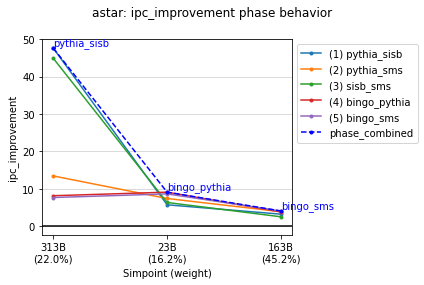

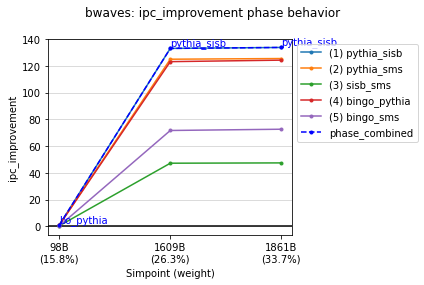

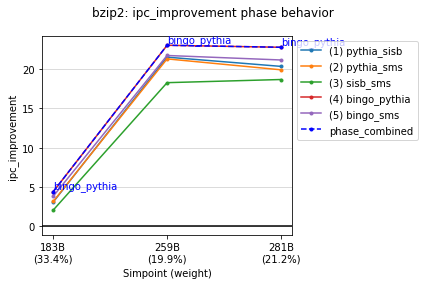

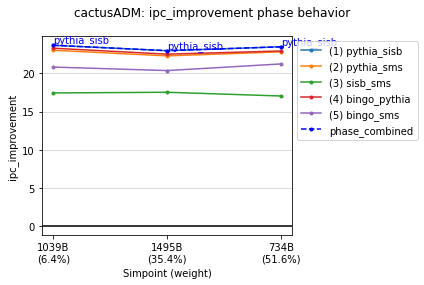

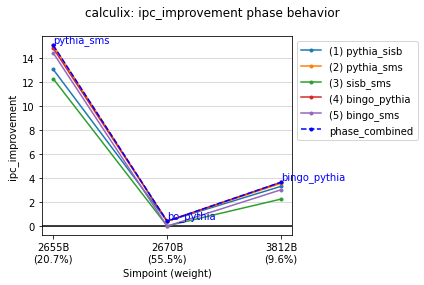

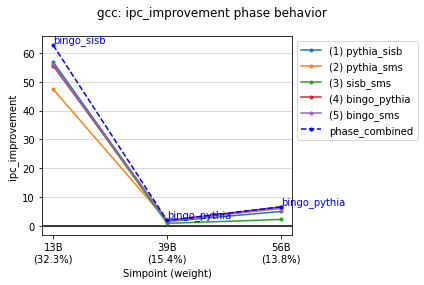

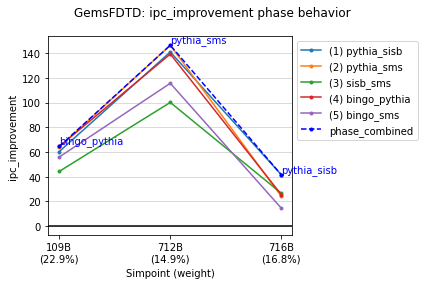

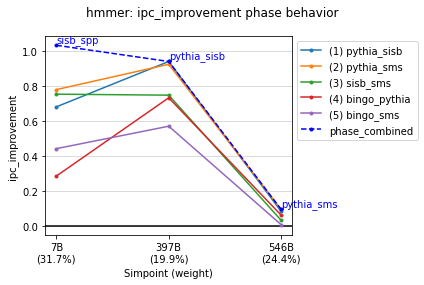

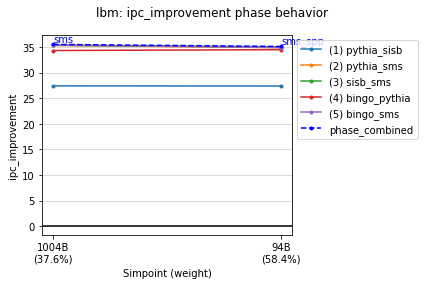

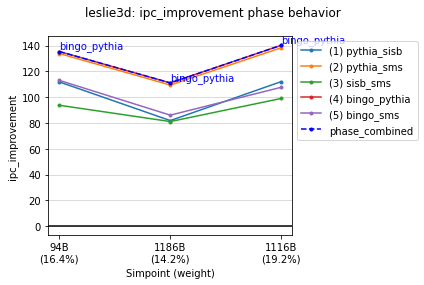

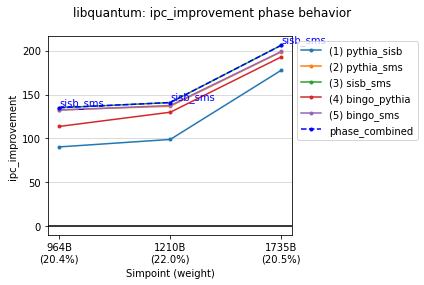

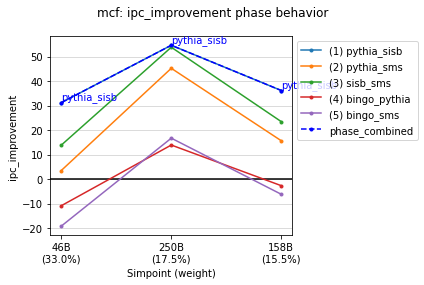

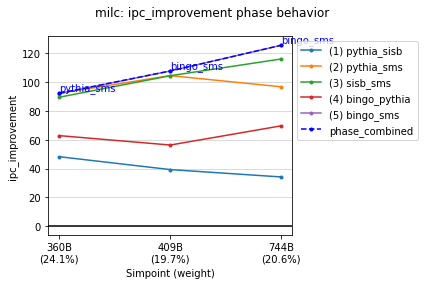

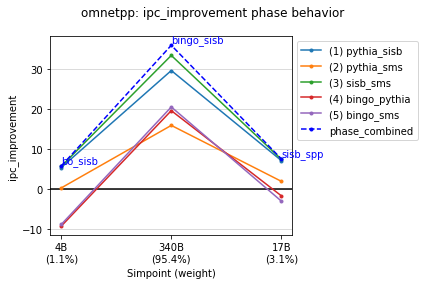

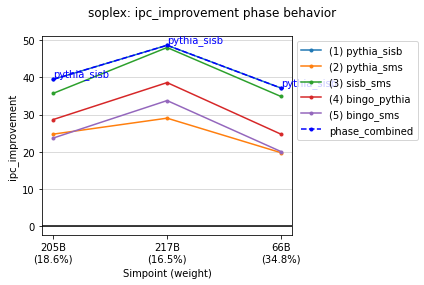

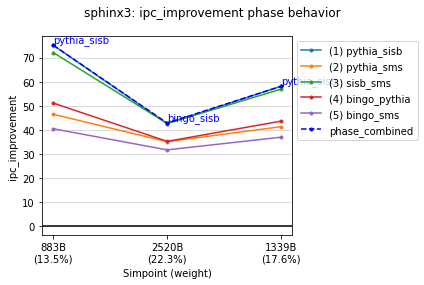

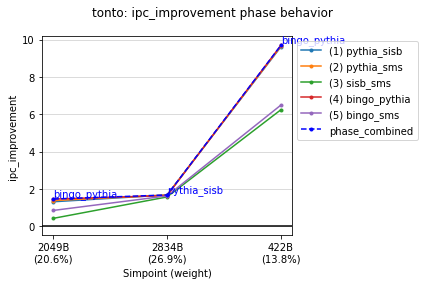

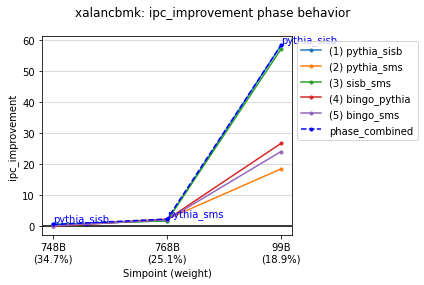

In [12]:
for tr in utils.spec:
    plot_phase_behavior(
        df, tr, 'ipc_improvement', weights=weights,
        prefetchers=spec_top_5,
        dpi=None,
    )
    plt.savefig(f'plots/zoo-phases/ipc_improvement_5_{tr}.pdf')

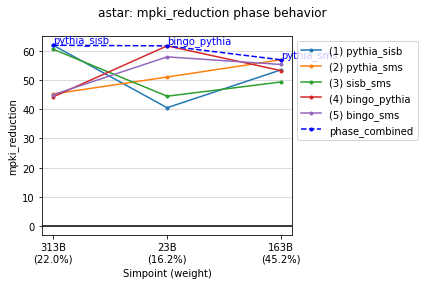

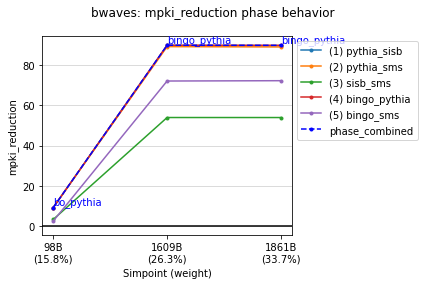

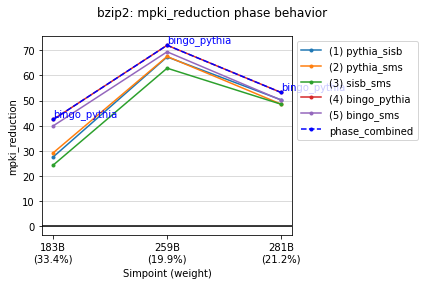

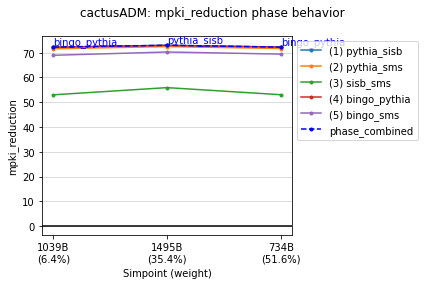

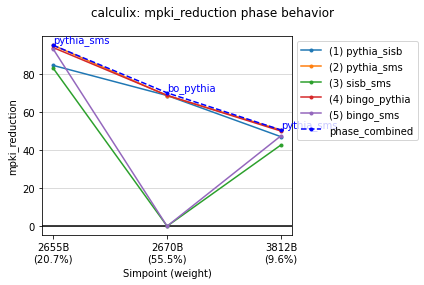

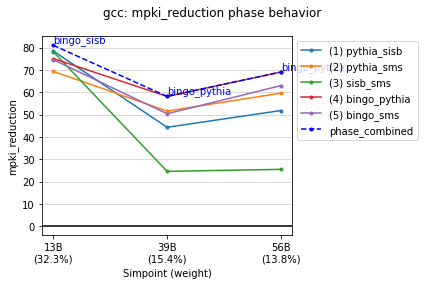

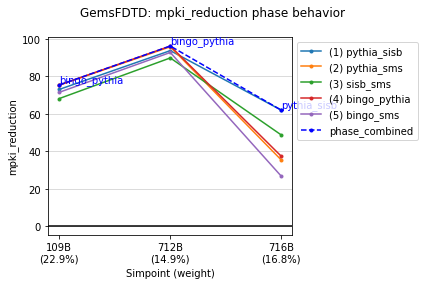

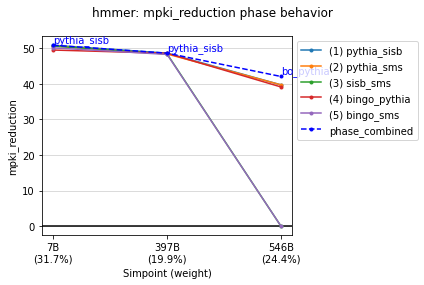

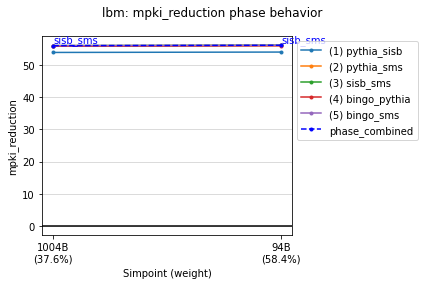

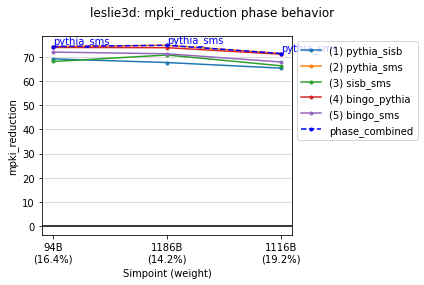

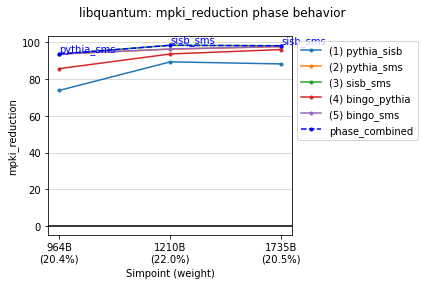

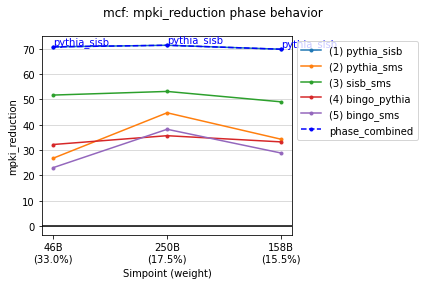

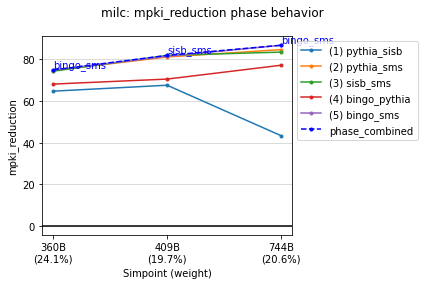

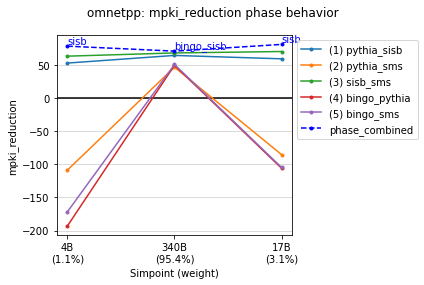

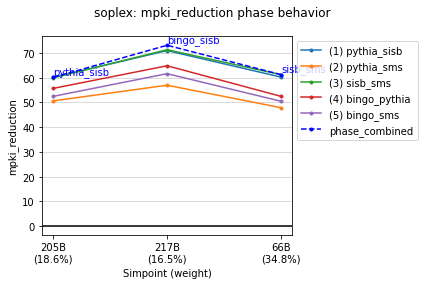

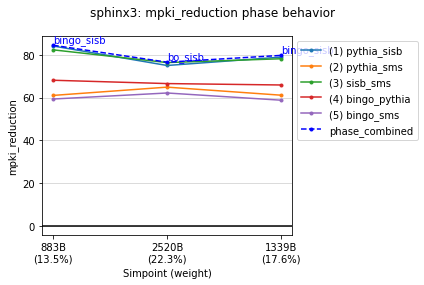

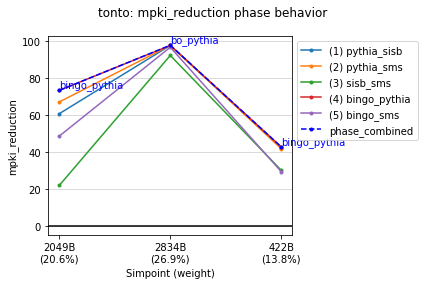

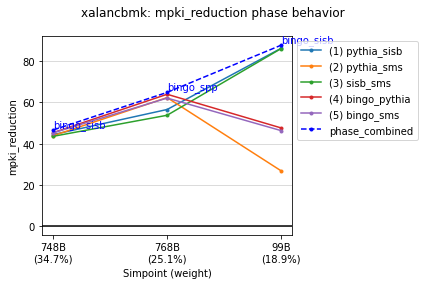

In [13]:
for tr in utils.spec:
    plot_phase_behavior(
        df, tr, 'mpki_reduction', weights=weights,
        prefetchers=spec_top_5,
        dpi=None,
        #ymin=-40, ymax=50
    )
    plt.savefig(f'plots/zoo-phases/mpki_reduction_5_{tr}.pdf')

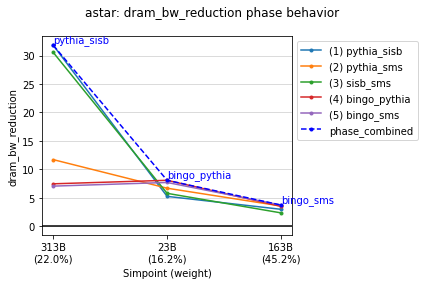

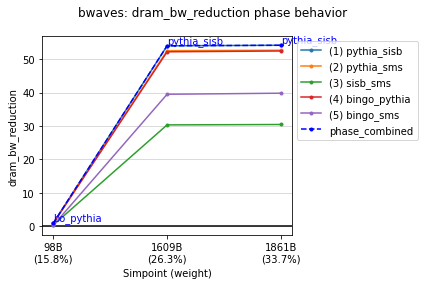

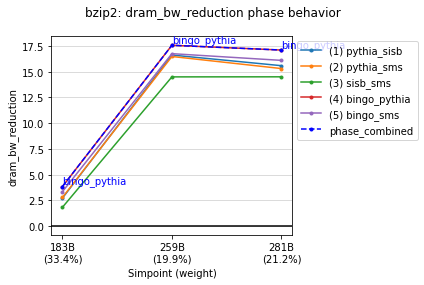

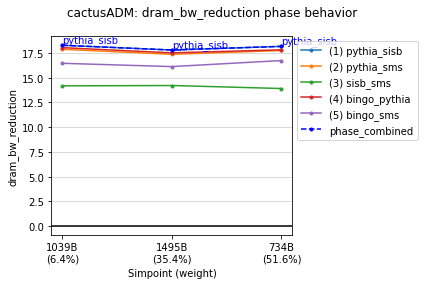

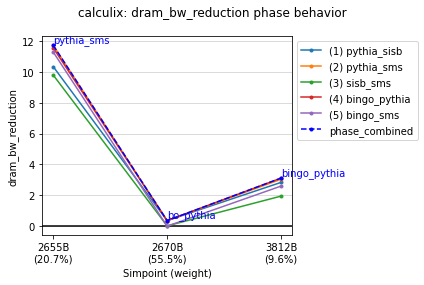

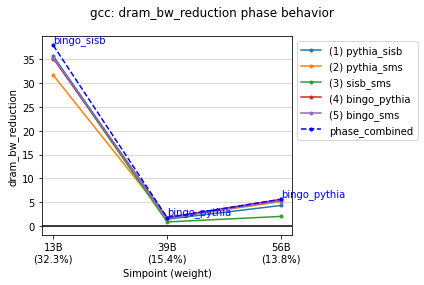

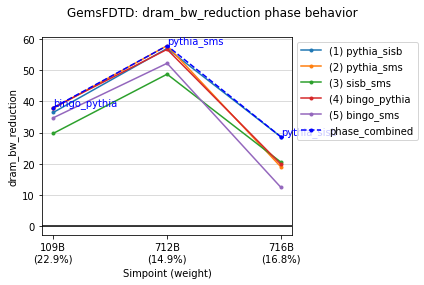

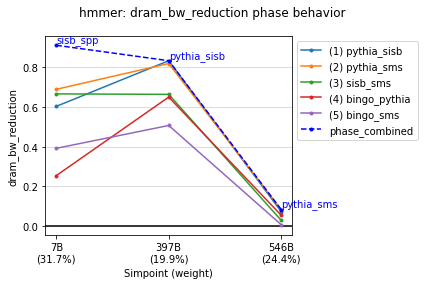

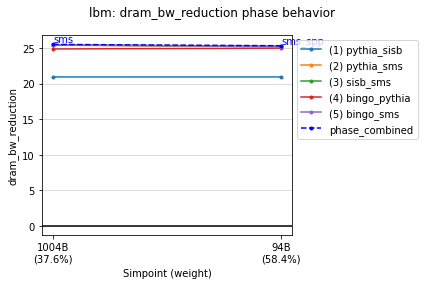

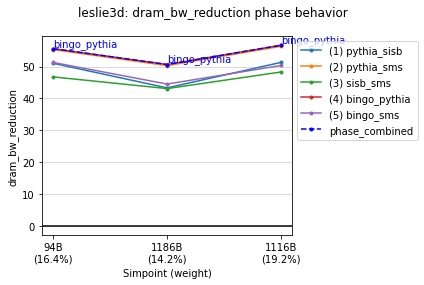

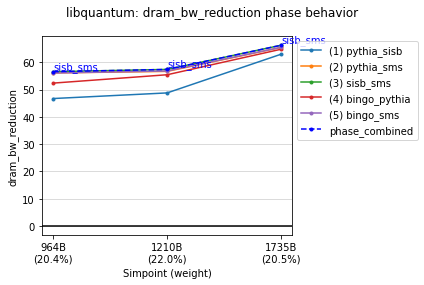

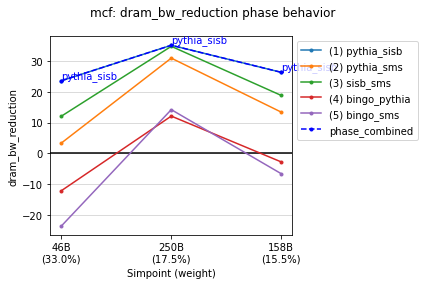

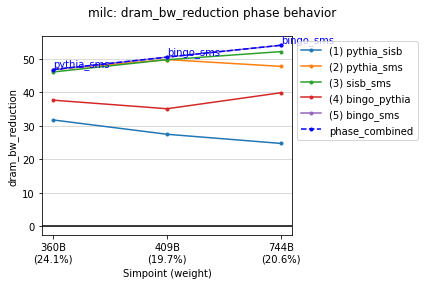

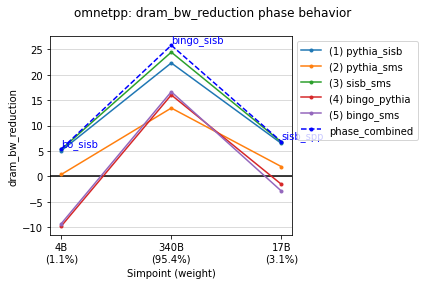

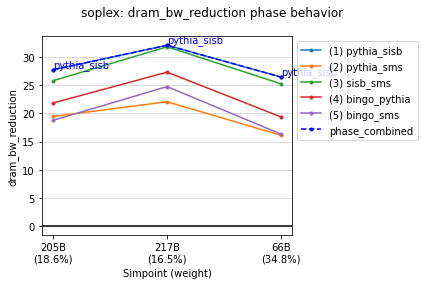

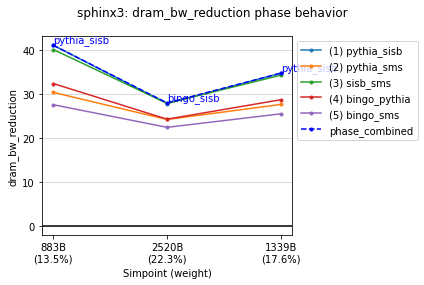

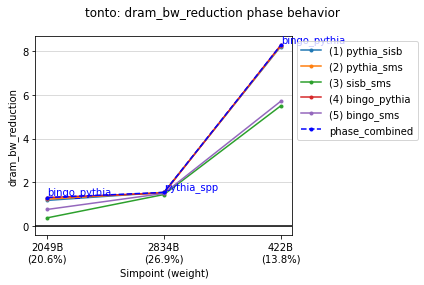

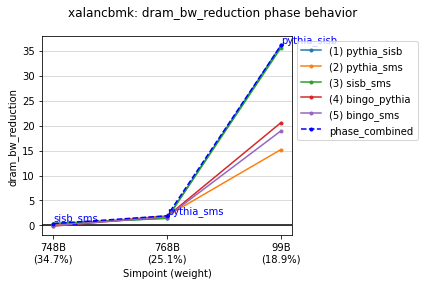

In [14]:
for tr in utils.spec:
    plot_phase_behavior(
        df, tr, 'dram_bw_reduction', weights=weights,
        prefetchers=spec_top_5,
        dpi=None,
        #ymin=-40, ymax=50
    )
    plt.savefig(f'plots/zoo-phases/dram_bw_reduction_5_{tr}.pdf')

---
## Cloudsuite phase behavior
## Top 5

In [15]:
cs_top_5 = utils.rank_prefetchers(df[df.trace.isin(utils.cloudsuite)], 'ipc_improvement', 5)
cs_top_5

['sisb_pythia', 'bingo_pythia', 'bingo_sisb', 'sms_pythia', 'bingo_spp']

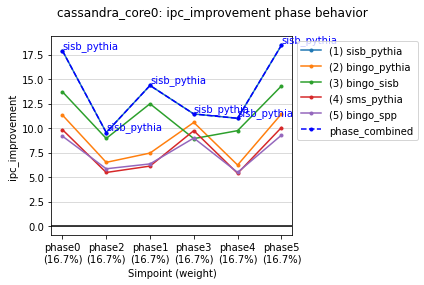

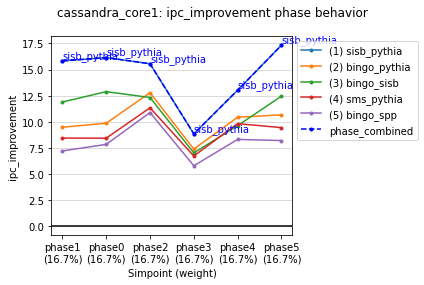

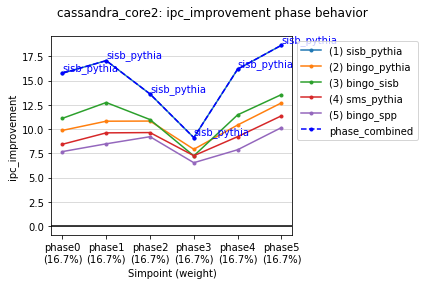

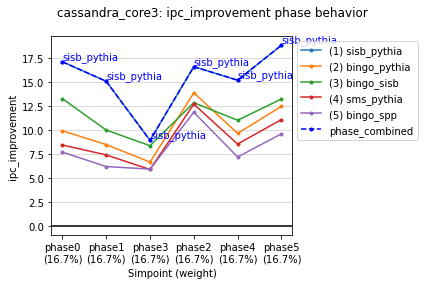

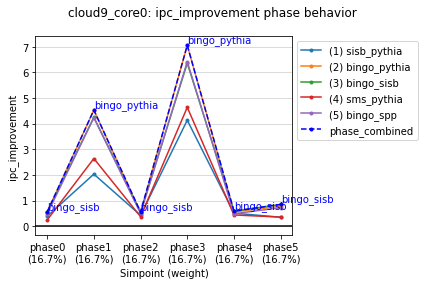

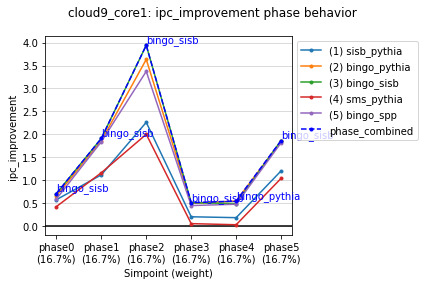

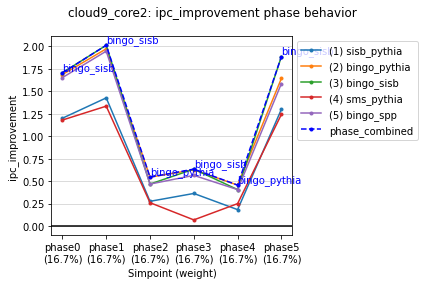

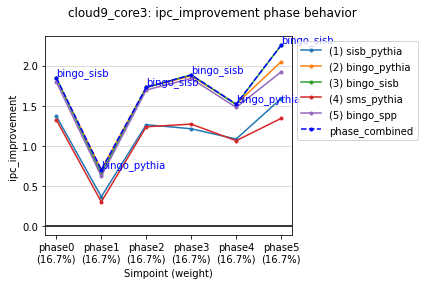

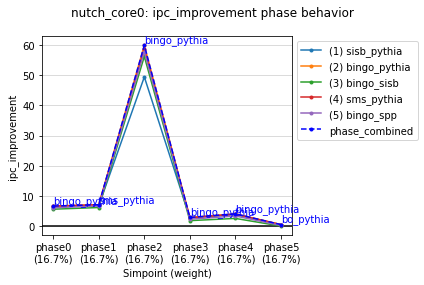

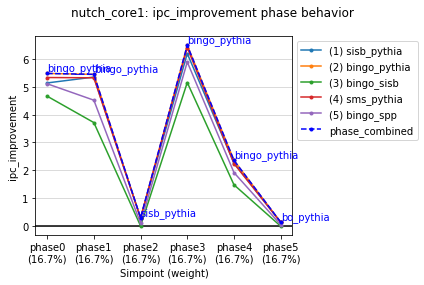

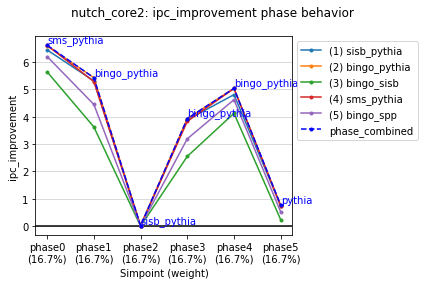

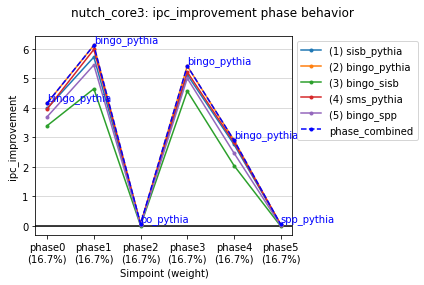

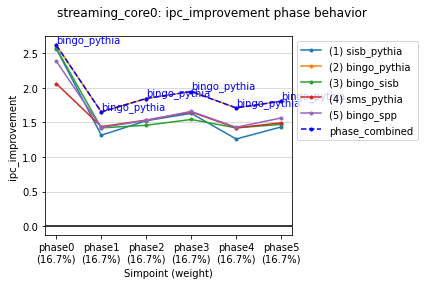

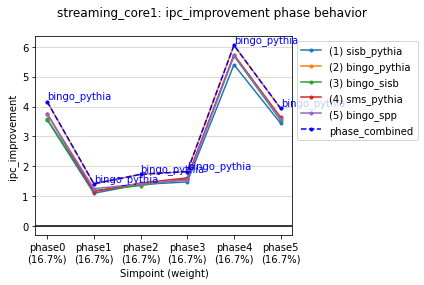

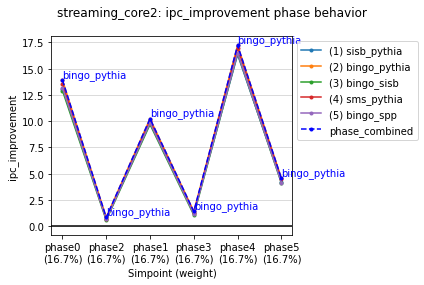

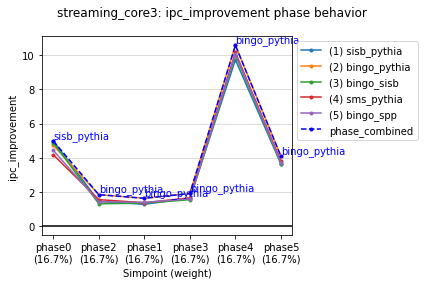

In [16]:
for tr in utils.cloudsuite:
    plot_phase_behavior(
        df, tr, 'ipc_improvement', weights=weights,
        prefetchers=cs_top_5,
        dpi=None,
    )
    plt.savefig(f'plots/zoo-phases/ipc_improvement_5_{tr}.pdf')

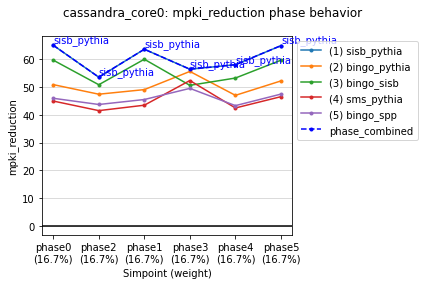

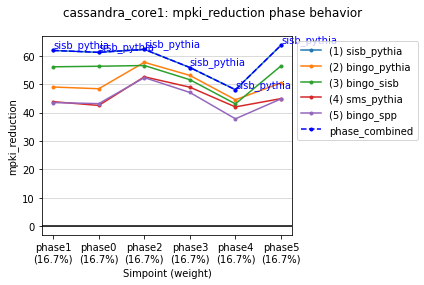

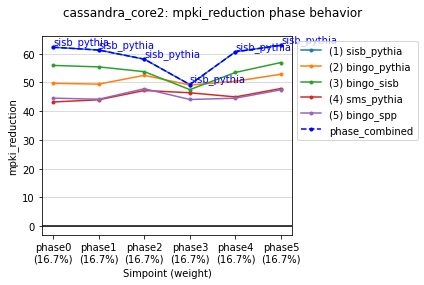

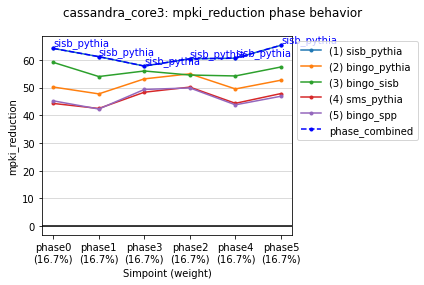

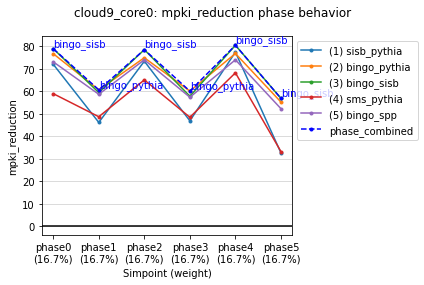

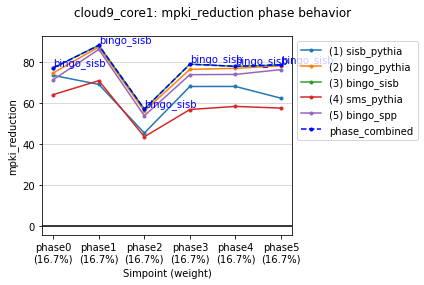

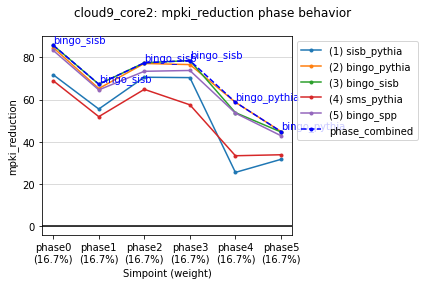

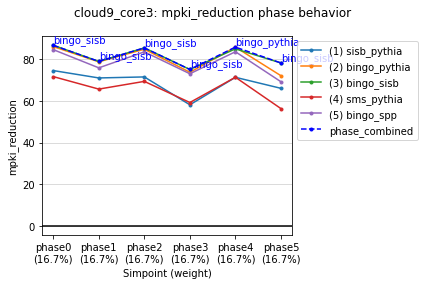

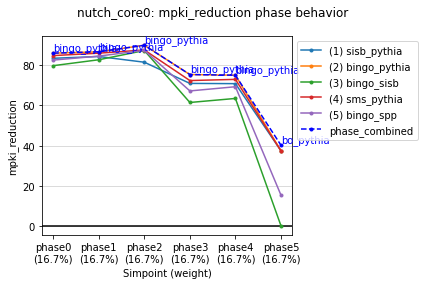

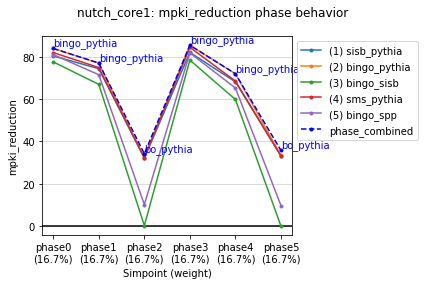

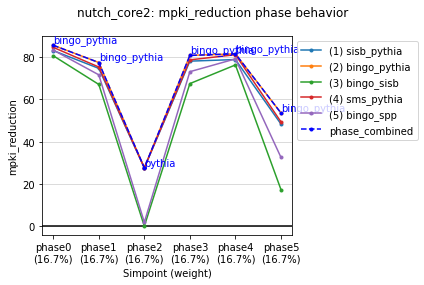

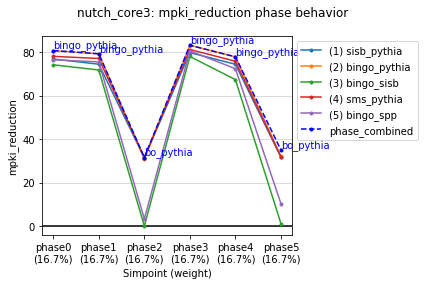

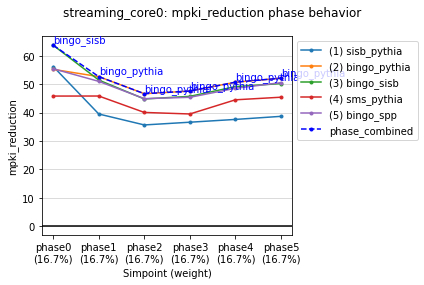

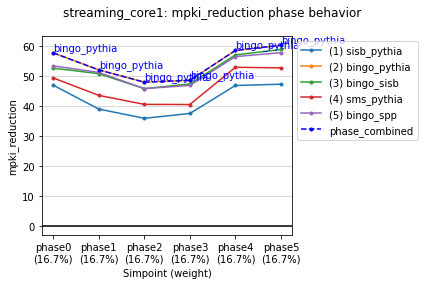

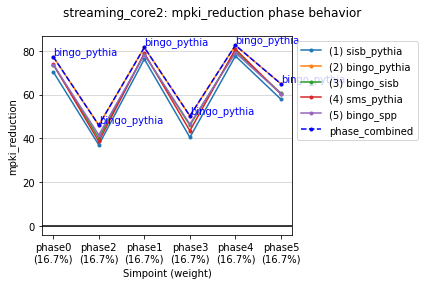

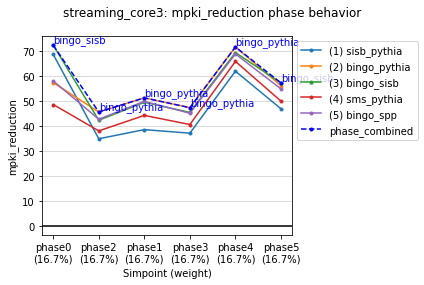

In [17]:
for tr in utils.cloudsuite:
    plot_phase_behavior(
        df, tr, 'mpki_reduction', weights=weights,
        prefetchers=cs_top_5,
        dpi=None,
    )
    plt.savefig(f'plots/zoo-phases/mpki_reduction_5_{tr}.pdf')

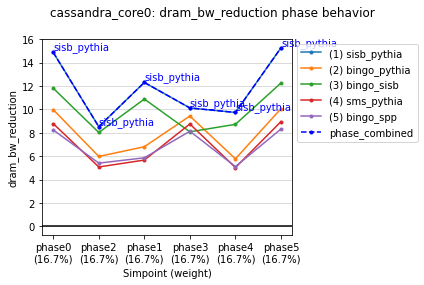

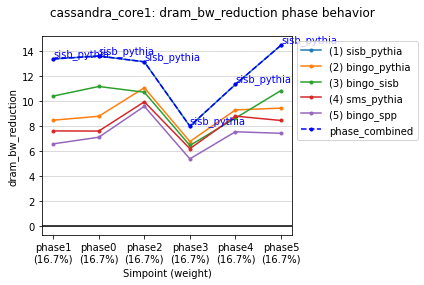

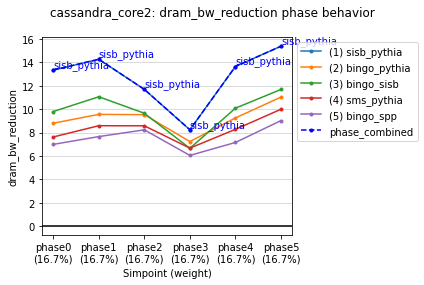

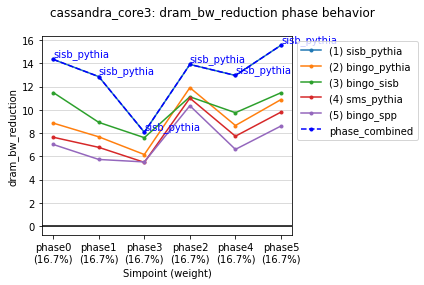

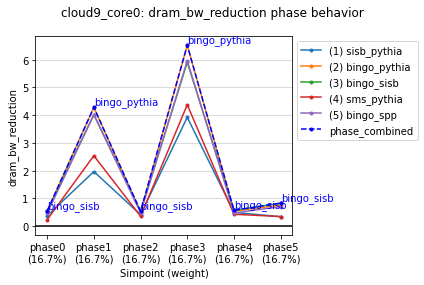

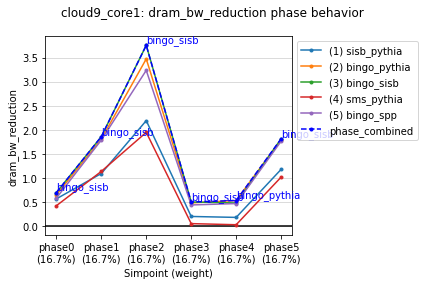

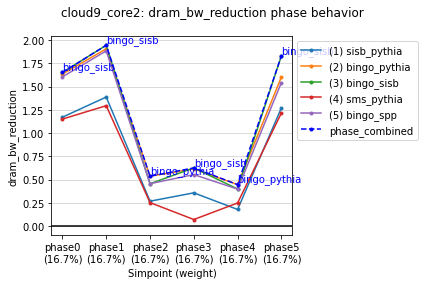

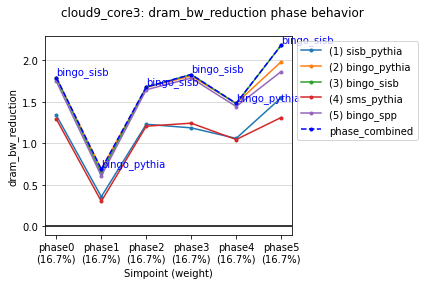

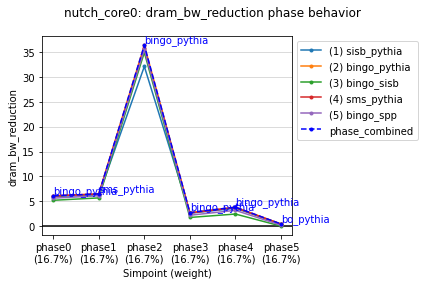

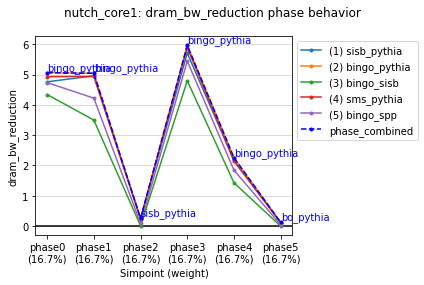

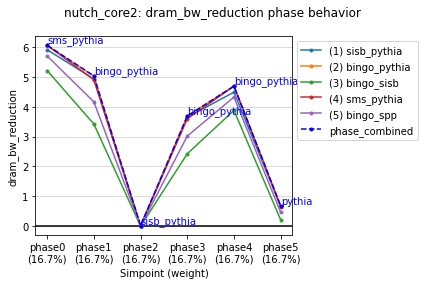

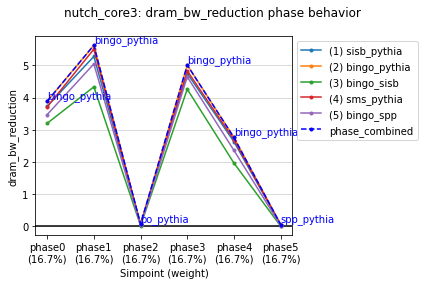

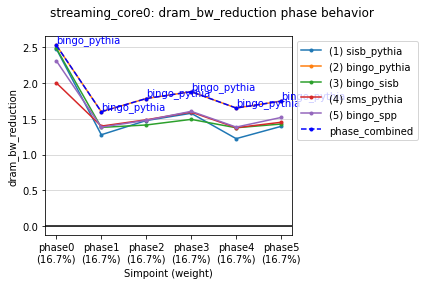

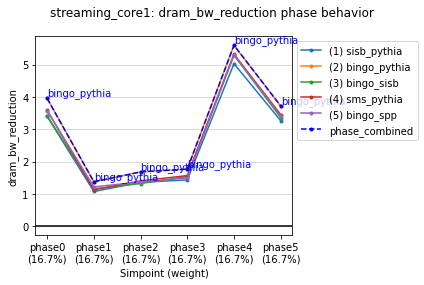

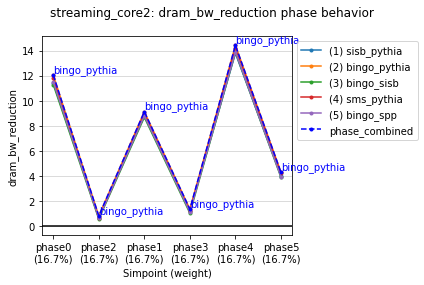

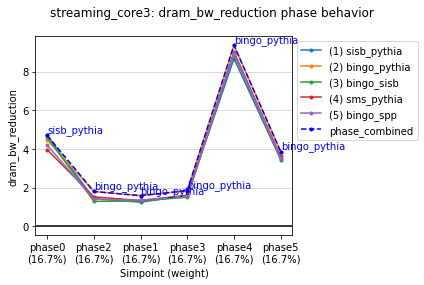

In [18]:
for tr in utils.cloudsuite:
    plot_phase_behavior(
        df, tr, 'dram_bw_reduction', weights=weights,
        prefetchers=cs_top_5,
        dpi=None,
    )
    plt.savefig(f'plots/zoo-phases/dram_bw_reduction_5_{tr}.pdf')